In [9]:
import pydicom
import open3d as o3d
import glob
import numpy as np
import copy

# Axial loading example

In [10]:
paths = [glob.glob("../data/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/702807833/*.dcm"), 
         glob.glob("../data/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/1054713880/*.dcm"),
         glob.glob("../data/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/2448190387/*.dcm")]

In [13]:
pydicom.dcmread(paths[0][0]).SeriesDescription

'T2'

In [5]:
pcds_xyz = []
pcds_d = []

for index, series in enumerate(paths):
    for path in series:
        slice = pydicom.read_file(path)
        img = np.expand_dims(slice.pixel_array, -1)
        pcd = o3d.geometry.PointCloud()
        
        x,y,z=np.where(img)
        
        index_voxel=np.vstack((x,y,z))
        grid_index_array=index_voxel.T

        vals = np.array([img[x,y,z] for x,y,z in grid_index_array]) 
        
        dX, dY = slice.PixelSpacing
        X = np.array(list(slice.ImageOrientationPatient[:3]) + [0]) * dX
        Y = np.array(list(slice.ImageOrientationPatient[3:]) + [0]) * dY
        S = np.array(list(slice.ImagePositionPatient) + [1])
                    
        pcd.points = o3d.utility.Vector3dVector(grid_index_array)
        
        transform_matrix = np.array([X, Y, np.zeros(len(X)), S]).T
        transform_matrix = transform_matrix @ np.matrix(
            [[0, 1, 0, 0],
            [1, 0, 0, 0],
            [0, 0, 1, 0],
            [0, 0, 0, 1]]
        )
        transformed_pcd = pcd.transform(transform_matrix)
        
        pcds_xyz.extend(transformed_pcd.points)
        pcds_d.extend(vals)

In [6]:
pcd_overall = o3d.geometry.PointCloud()
pcd_overall.points = o3d.utility.Vector3dVector(pcds_xyz)
pcd_overall.colors.extend(o3d.utility.Vector3dVector(np.repeat(np.expand_dims(pcds_d, -1) / 256, 3, -1)))

In [7]:
o3d.visualization.draw_geometries([pcd_overall])

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


In [8]:
voxel_grid = o3d.geometry.VoxelGrid().create_from_point_cloud(pcd_overall, dX)
o3d.visualization.draw_geometries([voxel_grid])

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


In [1]:
from rsna_dataloader import *

# series = read_series_as_voxel_grid("../data/rsna-2024-lumbar-spine-degenerative-classification/train_images/22191399/3687121182")
study = read_study_as_voxel_grid("../data/rsna-2024-lumbar-spine-degenerative-classification/train_images/22191399/")
# study_pcd = read_study_as_pcd("../data/rsna-2024-lumbar-spine-degenerative-classification/train_images/22191399/")
#series = read_series_as_pcd("../data/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/2448190387/")

In [2]:
# o3d.visualization.draw_geometries([study_pcd])

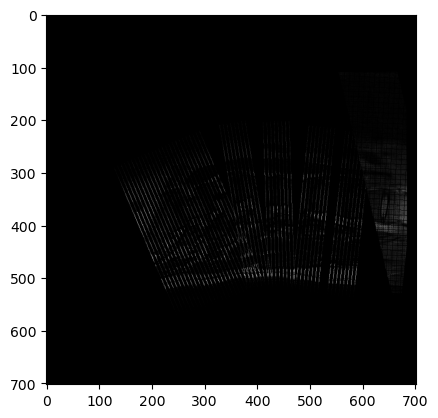

In [26]:
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(study[1, 150, :, :], cmap="gray")

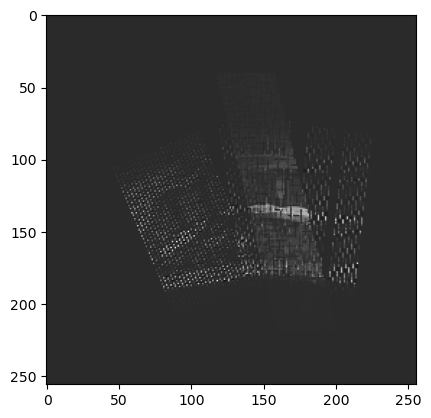

In [37]:
import cv2

plt.imshow(cv2.resize(study[1, 170, :, :], dsize=(256, 256), interpolation=cv2.INTER_CUBIC), cmap="gray")

In [18]:
import open3d as o3d

x, y, z = np.where(series)

index_voxel = np.vstack((x, y, z))
grid_index_array = index_voxel.T

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(grid_index_array)
vals = np.array([series[x, y, z] for x, y, z in grid_index_array])
pcd.colors = o3d.utility.Vector3dVector(np.repeat(np.expand_dims(vals, -1) / 256, 3, -1))

In [19]:
o3d.visualization.draw_geometries([pcd])

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
